In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### Preprocess Data

In [2]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='eg_30T', 
    freq=30,
    normalize_time=True
    )

### 30 minutes agg.

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


#covar_module = locally_short_periodic + locally_long_periodic + local_variation ## best

covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

### Create, Train, and Perform Inference

In [ ]:
for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='eg_30T', 
    freq=30,
    normalize_time=True)

    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=kernel,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1, 
    time_agg='30T',
    machine='eg',
    update_score=True
)

Iter 1 , Loss = 0.9561894698184518 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.9168885438313218 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8780132549056773 , Noise = 0.5982138514518738
Iter 4 , Loss = 0.8391955971957893 , Noise = 0.5543694496154785
Iter 5 , Loss = 0.8001612723312093 , Noise = 0.5129261612892151
Iter 6 , Loss = 0.761103794103693 , Noise = 0.4738385081291199
Iter 7 , Loss = 0.7222046539232841 , Noise = 0.4370555877685547
Iter 8 , Loss = 0.6835267905868729 , Noise = 0.4025220274925232
Iter 9 , Loss = 0.6451847352895834 , Noise = 0.3701780438423157
Iter 10 , Loss = 0.6074639031089349 , Noise = 0.3399597108364105
Iter 11 , Loss = 0.5711487590299765 , Noise = 0.3117991089820862
Iter 12 , Loss = 0.536844335197074 , Noise = 0.28562551736831665
Iter 13 , Loss = 0.5041163568872284 , Noise = 0.26136648654937744
Iter 14 , Loss = 0.4717024814193573 , Noise = 0.23894467949867249
Iter 15 , Loss = 0.4388137033146015 , Noise = 0.21827316284179688
Iter 16 , Loss = 0.4054581801233

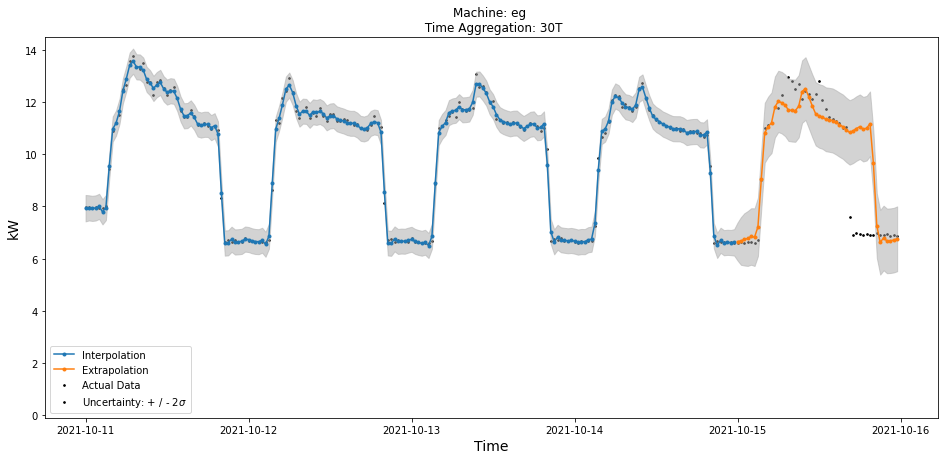

                 time     actual machine
0 2021-10-13 20:00:00  10.204072      eg


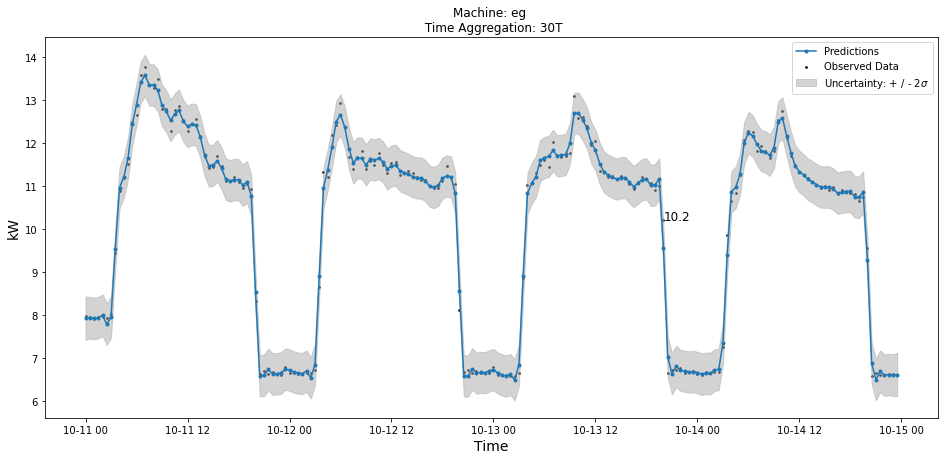

   index                time machine control_limit  actual_kw  expected_kw  \
0      0 2021-10-15 07:30:00      eg         upper  12.958107    11.693543   
1      1 2021-10-15 12:00:00      eg         upper  12.819345    11.465193   
2      0 2021-10-15 16:30:00      eg         lower   7.582881    10.833917   
3      1 2021-10-15 17:00:00      eg         lower   6.917274    10.892612   
4      2 2021-10-15 17:30:00      eg         lower   6.991560    10.984139   
5      3 2021-10-15 18:00:00      eg         lower   6.940987    11.053574   
6      4 2021-10-15 18:30:00      eg         lower   6.894207    10.958116   
7      5 2021-10-15 19:00:00      eg         lower   6.951869    10.996425   
8      6 2021-10-15 19:30:00      eg         lower   6.912957    11.165881   
9      7 2021-10-15 20:00:00      eg         lower   6.896309     9.659488   

       bound  
0  12.880938  
1  12.680466  
2   9.599463  
3   9.657287  
4   9.748039  
5   9.816778  
6   9.720707  
7   9.758543  
8   9.

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:516: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:517: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')


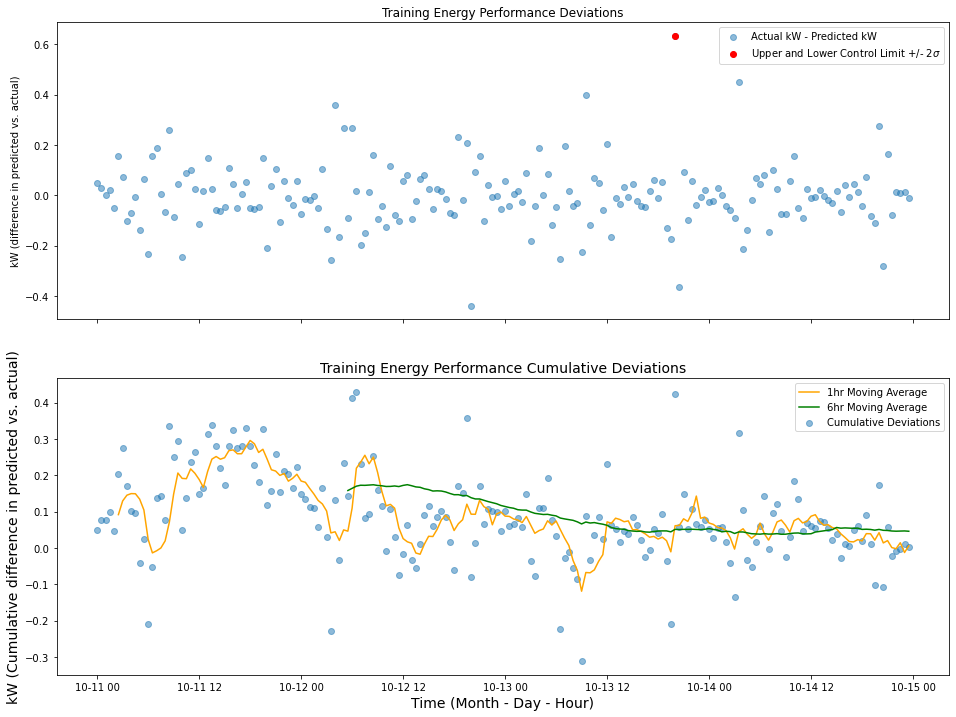

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:543: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_upper], test_deviation[test_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:544: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_lower], test_deviation[test_lower], color='red')


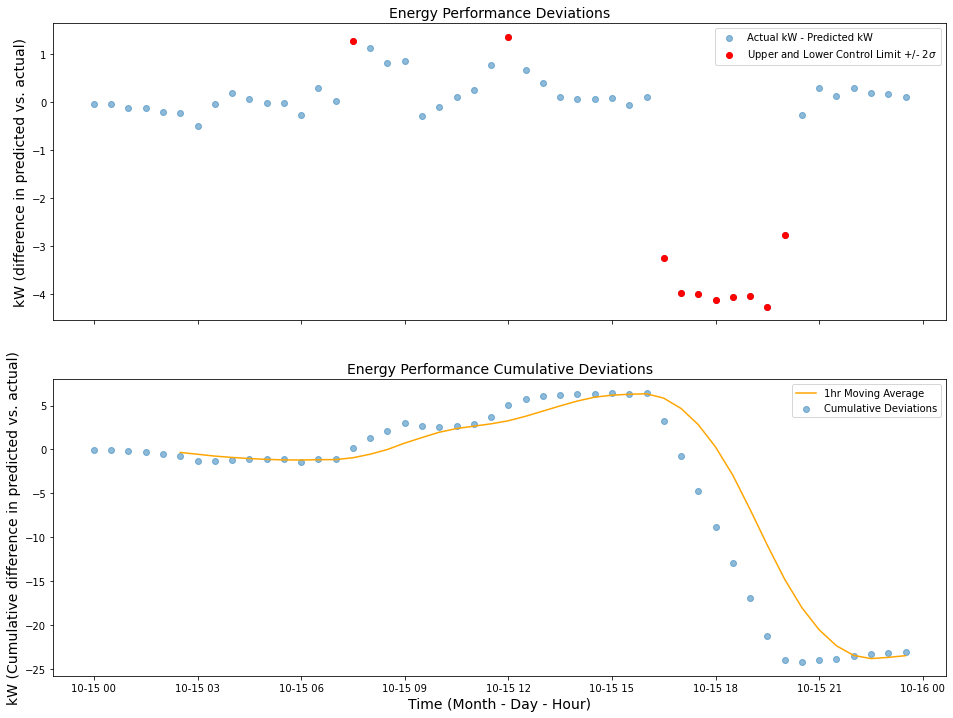

0.7916666666666666 0.44309102377814114


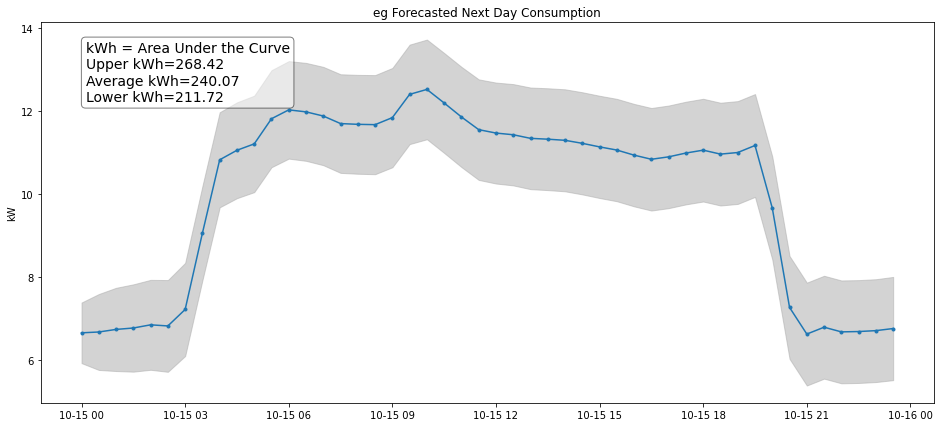

In [4]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module1,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='30T',
    lr=0.1, 
    machine='eg',
    update_score=False
)

In [5]:
mse, mape

(2.629507016783393, 0.11482377180372104)

### 10 minutes agg..

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='eg_10T', 
    freq=10,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.09) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


#covar_module = locally_short_periodic + locally_long_periodic + local_variation ## best

#covar_module = locally_short_periodic
#covar_module = locally_short_periodic + local_variation  
#covar_module = locally_short_periodic + locally_long_periodic

#covar_module = locally_long_periodic
covar_module = locally_long_periodic + local_variation

#covar_module = local_variation

In [ ]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='10T',
    lr=0.1, 
    machine='eg',
    update_score=False
)

In [ ]:
mse, mape